In [1]:
from Chemometrics.import_common import *
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'

In [2]:
# 读取数据
with open('数据汇总.csv') as csv:
    df = pd.read_csv(csv,delimiter='\t')
hplc = df.dropna(axis=1)
LC = hplc.drop(0).set_index('样品名称').loc[:,'1':]
ir = pload('tw20_IR.p')

In [3]:
# 整理数据: 结构化
try:
    LC.index = [re.search('.+(?=-)',idx)[0] for idx in LC.index]
except:pass
lc = LC.groupby(LC.index).mean()
ir.index = ir.index.map(str.lower)
ir = ir.groupby(ir.index).mean()
common_observation = np.intersect1d(ir.index,lc.index)
Y = ir.loc[common_observation] #NIR
X = lc.loc[common_observation] #LC

# 互信息Mutual imformation计算   
 

<h1 style="text-align:center">I(X, Y) = H(X) + H(Y) - H(X,Y) </h1>

在概率论和信息论中，两个随机变量的互信息（Mutual Information，简称MI）或转移信息（transinformation）是变量间相互依赖性的量度。详细可参考[这里](https://zh.wikipedia.org/wiki/%E4%BA%92%E4%BF%A1%E6%81%AF)

计算NIR每个波数的吸光度和LC每个峰之间的互信息，以此来表示NIR和LC之间的联系 

In [4]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest
sk = SelectKBest(mutual_info_regression,1)
mi = []
for peak in X.columns:
    sk.fit(Y,X[peak])
    mi.append(sk.scores_)
MI = pd.DataFrame(mi, index=X.columns, columns=np.round(Y.columns.values))

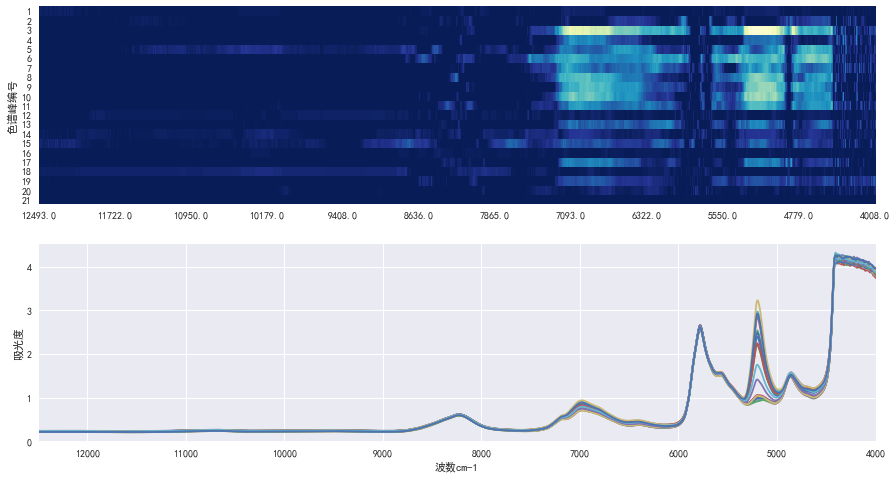

In [18]:
f = plt.figure(figsize=(15,20))
ax1 = f.add_subplot(211)
g = sns.heatmap(MI,xticklabels=200,cmap=plt.cm.YlGnBu_r,ax=ax1,cbar=False)
plt.ylabel('色谱峰编号')
plt.yticks(rotation=0)
ax2 = f.add_subplot(212)
Y.T.plot(figsize=(15,8),legend=False,ax=ax2)
plt.xlabel('波数cm-1')
plt.ylabel('吸光度')
f.savefig('NIR和IR之间的互信息.png',dpi=300)

In [6]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression,SelectKBest

In [7]:
pca = PCA(n_components=.99)
_Scores = pca.fit_transform(Y)

In [27]:
def mi_pair(X, Y):
    # X: a*b
    # Y: m*n
    # return: m*b
    
    _mi = []
    for i in range(Y.shape[1]):
        _mi.append(mutual_info_regression(X, Y[:,i]))
    return np.vstack(_mi)

In [37]:
mi_pca = mi_pair(_Scores, X.values)

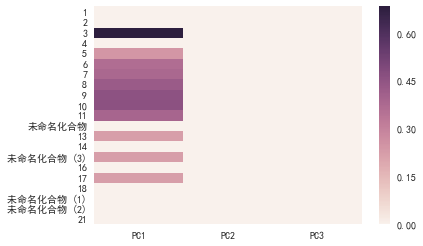

In [96]:
mi_threshold = .2
data = pd.DataFrame(mi_pca, index=X.columns, columns=['PC1','PC2','PC3'])
_data = data.where(data>mi_threshold, 0)
sns.heatmap(_data)

Text(0,0.5,'MI')

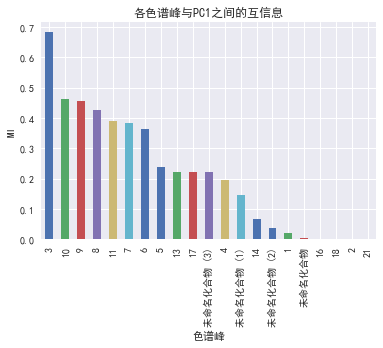

In [103]:
data.PC1.sort_values(ascending=False).plot.bar()
plt.title('各色谱峰与PC1之间的互信息')
plt.xlabel('色谱峰')
plt.ylabel('MI')

In [76]:
s = pd.Series(mutual_info_regression(Y.values, _Scores[:,0]))

Text(0,0.5,'MI')

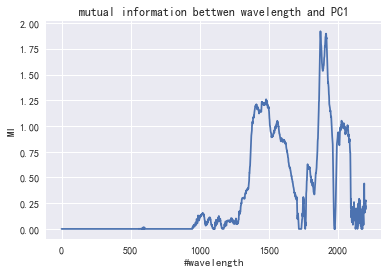

In [91]:
plt.plot(s)
plt.title('mutual information bettwen wavelength and PC1')
plt.xlabel('#wavelength')
plt.ylabel('MI')

In [119]:
#各色谱峰之间的关系
mi_peaks = mi_pair(X.values, X.values)
_d = np.triu(mi_peaks, 1)
d = np.where(_d>.2, _d, 0)

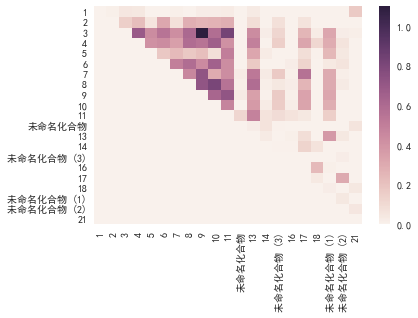

In [123]:
sns.heatmap(_d, xticklabels=X.columns.tolist(), yticklabels=X.columns.tolist())

为什么变量自己和自己的MI大小不一样？